In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import shap
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import copy
from IPython.display import clear_output

from util.util_cnn import CNNModel, data_loaders, first_mnist_batch, test, \
                params_to_filename, params_from_filename, load_mnist_v4_models

from util.naming import *
from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_tutorial import heatmap
from util.util_pickle import *

# pan kessel
from explanations_can_be_manipulated.src.nn.enums import ExplainingMethod, LRPRule
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet
from explanations_can_be_manipulated.src.nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

device = 'cpu'
method = ExplainingMethod.lrp

no display found. Using non-interactive Agg backend


In [2]:
# load data and pretrained models
batch_size = 100

data, target = first_mnist_batch(batch_size=batch_size)
background, background_target = first_mnist_batch(batch_size=batch_size, test=False)

background = background.reshape((-1, 1, 28, 28))
test_images = data[:3].reshape((-1, 1, 28, 28))

shap_config = 'shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0'
test_loader_shap = data_loaders(shapley_values_for=('d3', shap_config), shuffle=False, batch_size=batch_size)

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2467/2467 [00:08<00:00, 305.83it/s]


## Cleaning up directories

In [136]:
assert 0
for fn in tqdm(sorted(os.listdir(PICKLE_PATH + 'd3'))):
    if ('shap__background' in fn) and ('0840.pickle' not in fn):
        os.remove(PICKLE_PATH + 'd3/' +fn)
        print(1, end='')

  0%|          | 0/157 [00:00<?, ?it/s]

111111111111111111111111111111111111111111111111111111111111111111111111111

In [135]:
for fn in tqdm(sorted(os.listdir(PICKLE_PATH + 'd3'))):
    if 'shap__background' in fn:
        pass #print(fn)

  0%|          | 0/19 [00:00<?, ?it/s]

## Load precomputed shapley values

In [152]:
shap_configs = get_shap_configs('d3')
shap_configs

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:00<00:00, 656069.98it/s]


array(['shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0',
       'shap__background_size-400__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0'],
      dtype='<U77')

In [153]:
shaps_per_config = { config: load_shaps('d3', config) for config in shap_configs }
    
for config, data in (shaps_per_config.items()):
    print(config, data.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:03<00:00, 449.17it/s]


shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0 (8400, 10, 1, 28, 28)
shap__background_size-400__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0 (7900, 10, 1, 28, 28)


In [150]:
shaps = load_shaps('d3', shap_configs[0])
shaps.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:03<00:00, 424.82it/s]


(8400, 10, 1, 28, 28)

In [138]:
shaps1 = load_data('d3', 'shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0__batch-0001-0840')

In [139]:
shaps1.shape

(10, 10, 1, 28, 28)

tensor(8)


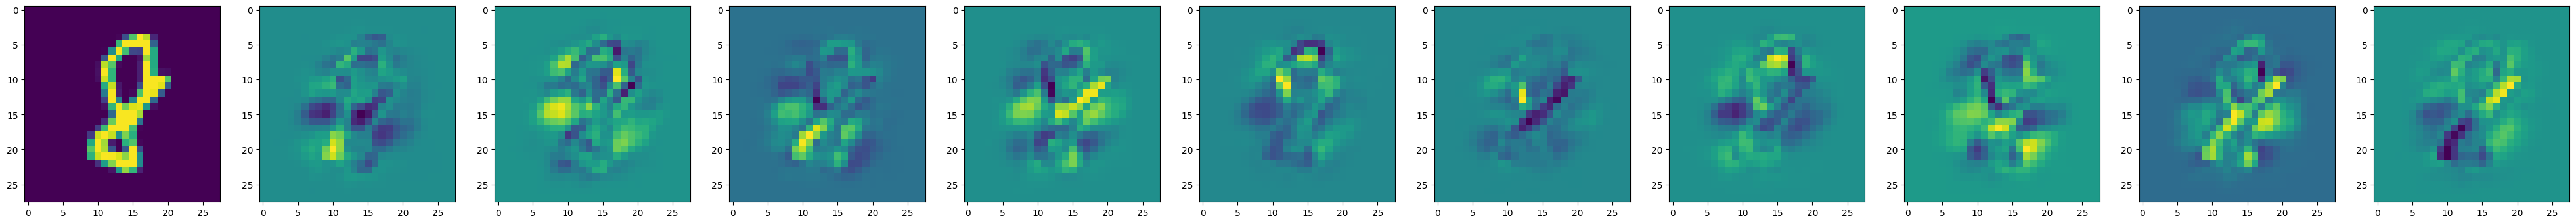

tensor(1)


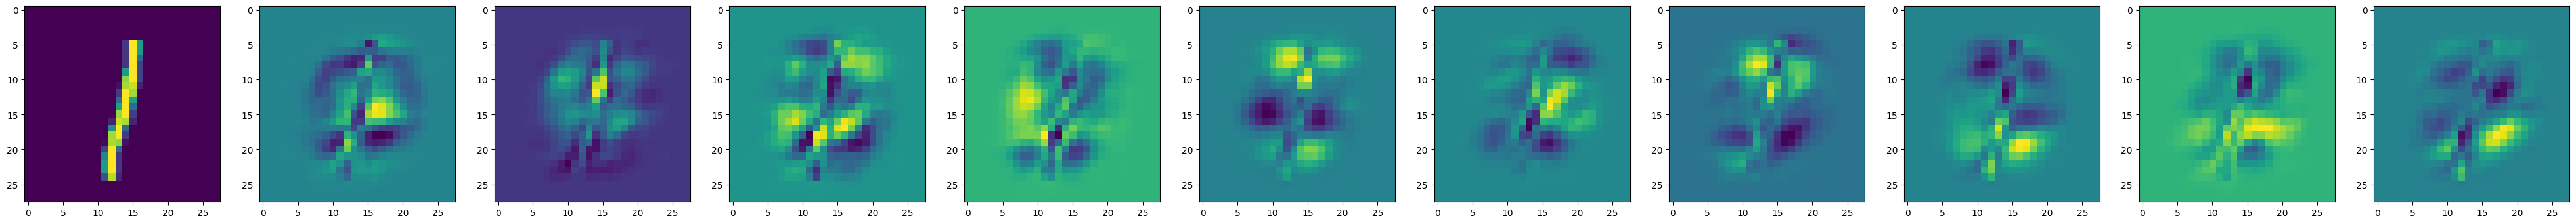

tensor(9)


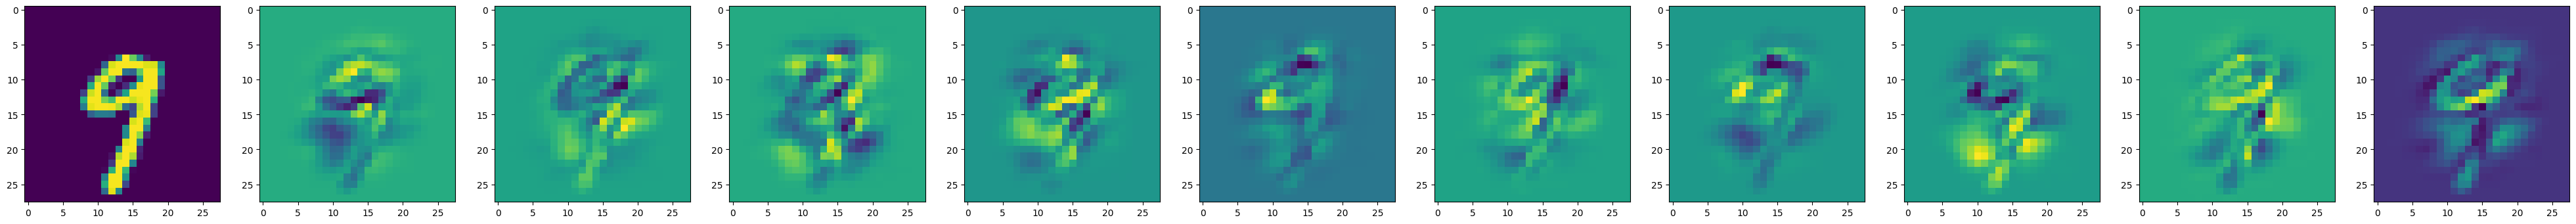

tensor(9)


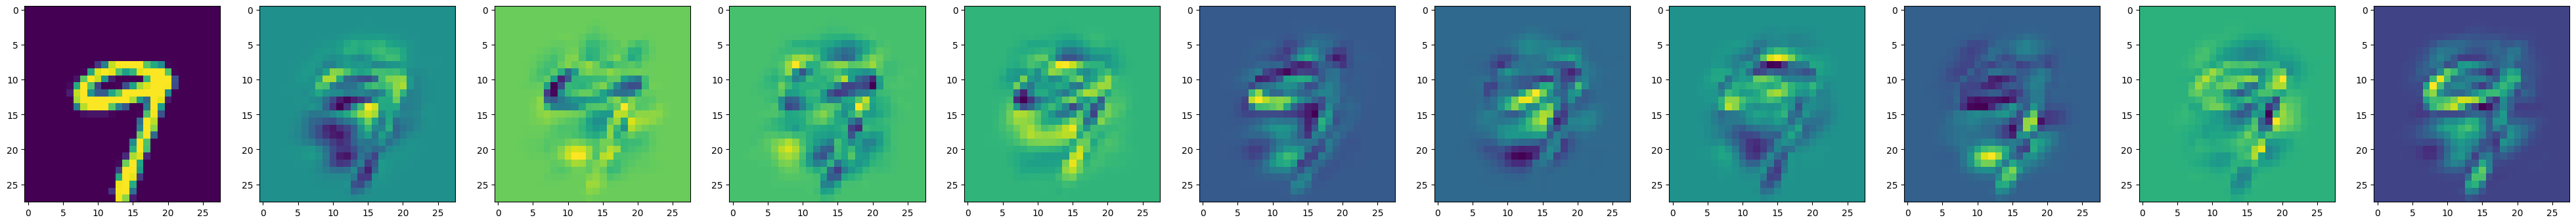

tensor(8)


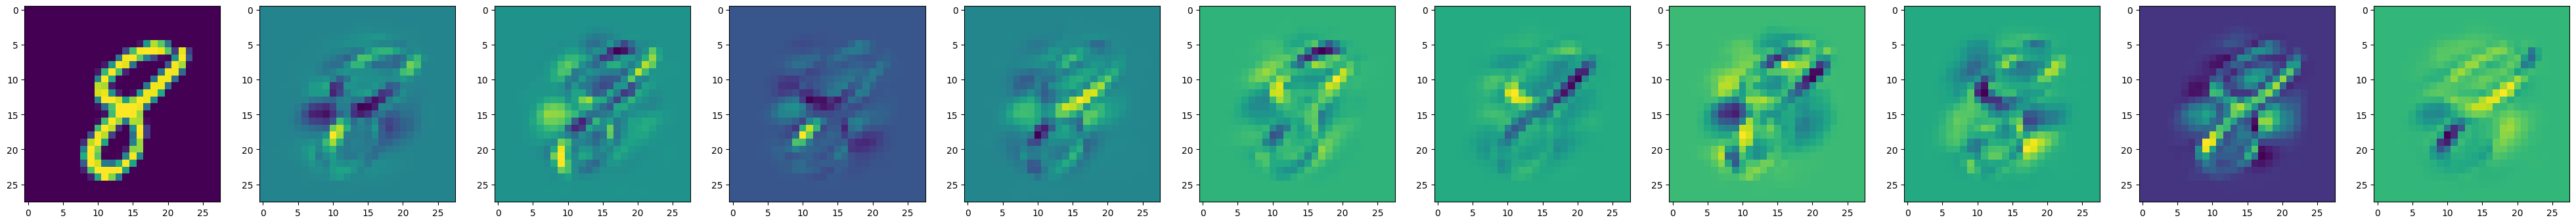

tensor(6)


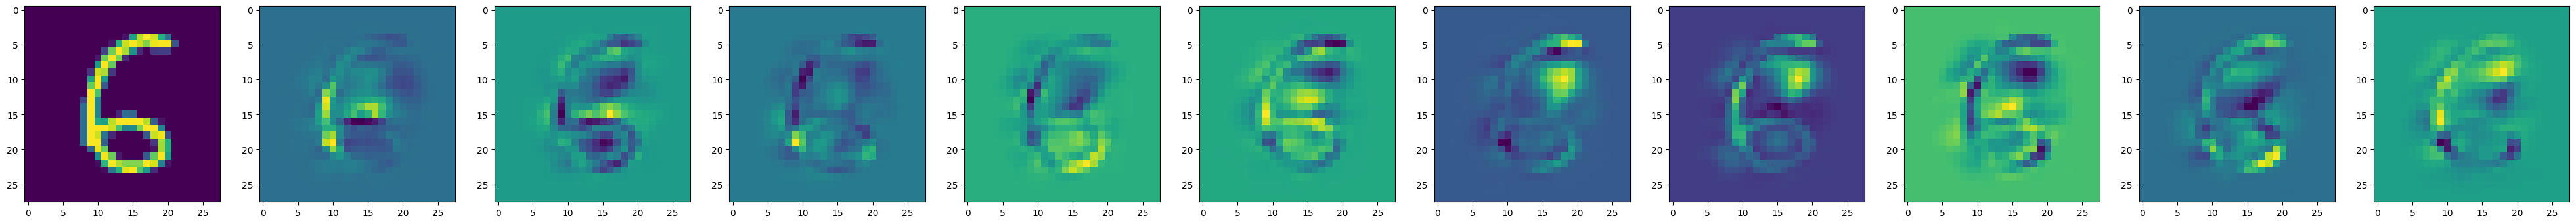

tensor(2)


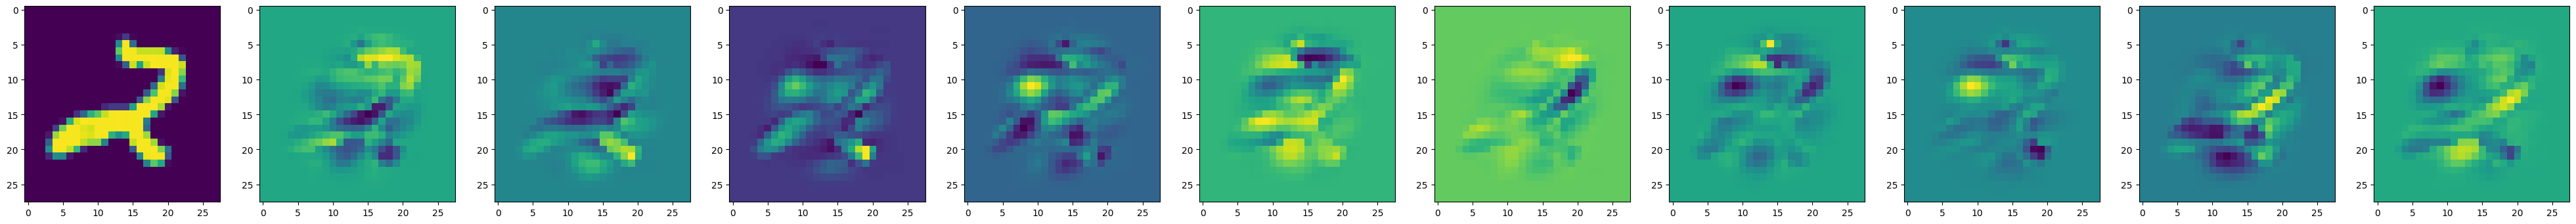

tensor(2)


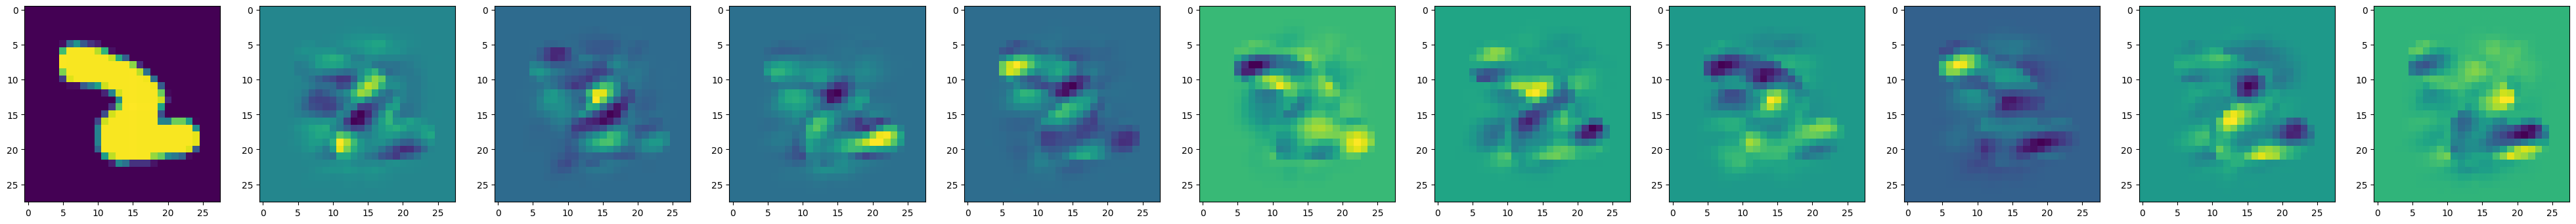

tensor(7)


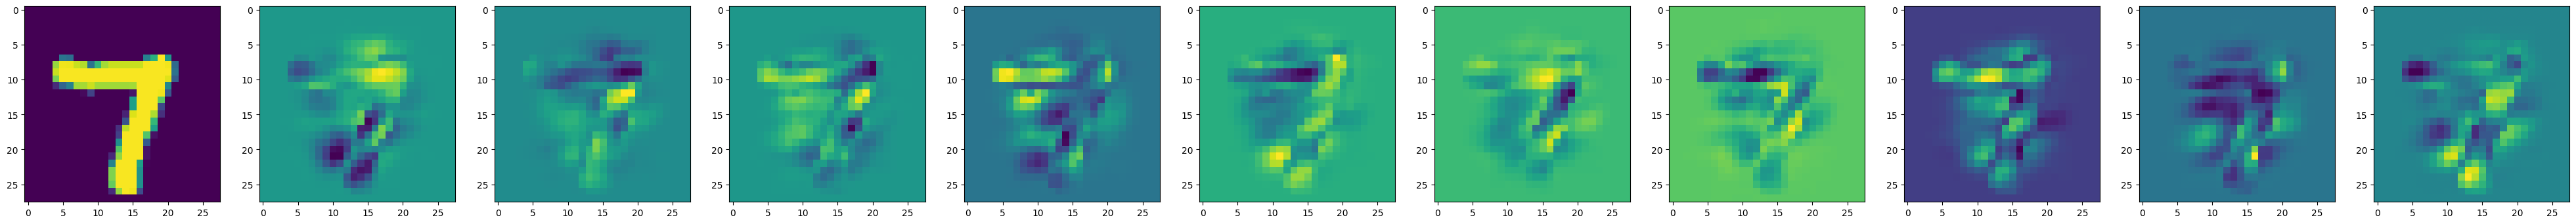

tensor(1)


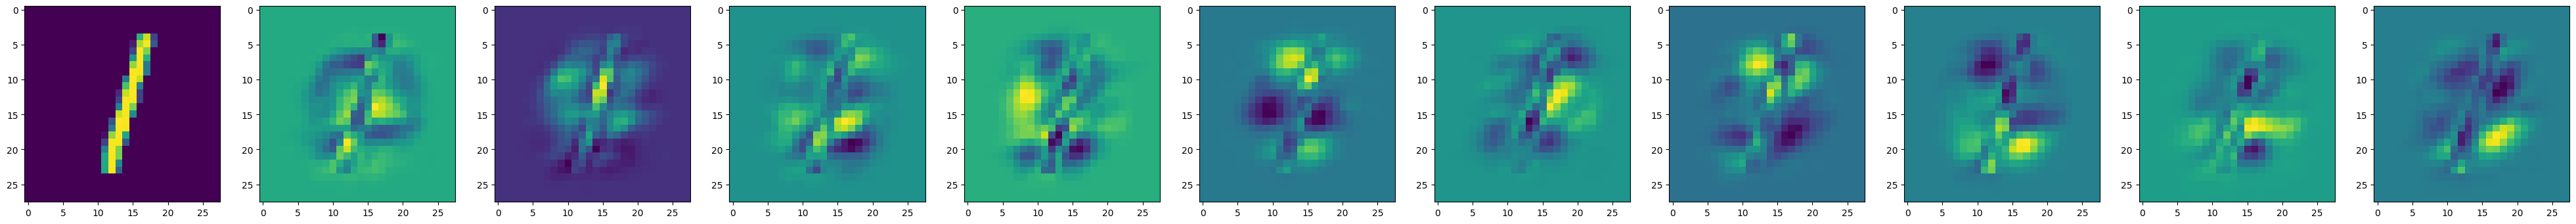

In [148]:
for a,b,c in test_loader_shap:
    a = a.reshape((-1, 28, 28))
    
    # c = c[np.arange(len(c)), b]
    # c = c.reshape((-1, 28, 28))
    # assert a.shape == c.shape
    
    for x, t, shap in zip(a, b, shaps1):
        print(t)
        fig, axs = plt.subplots(1, 11, figsize=(50, 20))
        axs[0].imshow(x)
        for i in range(10): axs[i+1].imshow(shap[i, 0])
        plt.show()

    break

In [ ]:
for x, expl_img in comb[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(shap_img)
    ax2.imshow(expl_img)
    plt.show()


## Import the Explainable model of Pan

In [ ]:
model = ExplainableNet(model_d3).eval().to(device)

In [5]:
gamma = 2
model.change_lrp_rules(gamma=gamma, lrp_rule_nl=LRPRule.gamma)

In [5]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 0.0 LRPRule.z_b
1 0.0 LRPRule.alpha_beta
2 0.0 LRPRule.alpha_beta
3 MaxPool
4 0.0 LRPRule.alpha_beta
5 0.0 LRPRule.alpha_beta
6 0.0 LRPRule.alpha_beta
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [48]:
x = data[:1].reshape((-1,1,28,28))
expl, output, classification = get_expl(model, test_images, method)

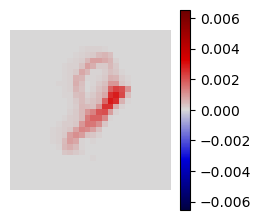

In [49]:
heatmap(expl[0].detach().reshape((28,28)), 2, 2, colorbar=True)

### Check equivalence to my implementation

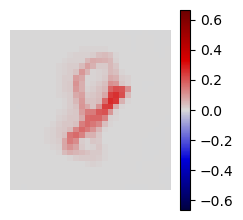

In [50]:
heatmap(rel(95)[0][0].reshape((28,28)), 2, 2, colorbar=True)

In [51]:
a = rel(95)[0][0, 0]
b = expl[0]

a.shape, b.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

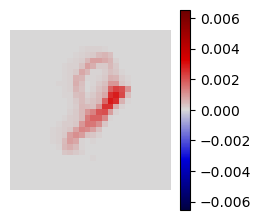

In [52]:
c = a
c[b>0] = b[b>0]
heatmap(c.detach(), colorbar=1)

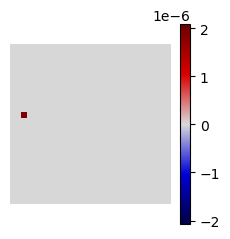

In [53]:
heatmap((a-b).detach(), colorbar=1)

In [54]:
np.abs((a-b).detach()).max()

tensor(1.9183e-06)

## SGD on Gamma

In [39]:
del ExplainableNet
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [5]:
model = ExplainableNet(model_d3).eval().to(device)

for i, l in enumerate(model.layers): print(i, str(l).split('(')[0])

0 Convolutional
1 Convolutional
2 Convolutional
3 MaxPool
4 Convolutional
5 Convolutional
6 Convolutional
7 MaxPool
8 Flatten
9 Dense


In [86]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 tensor([nan], requires_grad=True) LRPRule.z_b
1 tensor([nan], requires_grad=True) LRPRule.gamma
2 tensor([nan], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([nan], requires_grad=True) LRPRule.gamma
5 tensor([nan], requires_grad=True) LRPRule.gamma
6 tensor([nan], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [ ]:
del ExplainableNet
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [89]:
_, test_loader = data_loaders()

In [151]:
len(os.listdir(PICKLE_PATH + 'd3')), 1696

(1646, 1696)

In [91]:
first_batch_x, _ = first_mnist_batch()
first_batch_x.shape

torch.Size([100, 784])

In [36]:
loader_iter = iter(test_loader_shap)
batches = [next(loader_iter) for i in range(5)]

In [294]:
gamma_early = torch.Tensor([0.051]).requires_grad_(True)
gamma_late  = torch.Tensor([0.050]).requires_grad_(True)

model = ExplainableNet(model_d3).eval().to(device)
model.change_lrp_rules(gamma=gamma_early, lrp_rule_nl=LRPRule.gamma, start_l=0, end_l=3)
model.change_lrp_rules(gamma=gamma_late , lrp_rule_nl=LRPRule.gamma, start_l=4, end_l=8)

for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

parameters = [gamma_early, gamma_late]
optimizer = torch.optim.Adam(parameters, lr=0.02)

0 tensor([0.0510], requires_grad=True) LRPRule.z_b
1 tensor([0.0510], requires_grad=True) LRPRule.gamma
2 tensor([0.0510], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([0.0500], requires_grad=True) LRPRule.gamma
5 tensor([0.0500], requires_grad=True) LRPRule.gamma
6 tensor([0.0500], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [ ]:
llrp_tags = list(get_matching_tags('d3', 'llrp__V1__model=cb1-8-8-8_cb2-16-16-16_seed-0'))
[tag[47:] for tag in llrp_tags]

In [77]:
llrp_tags = list(get_matching_tags('d3', ['llrp__V1__model=cb1-8-8-8_cb2-16-16-16_seed-0', 'T=1e+06', 'shuffle']))
[tag[47:] for tag in llrp_tags]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2505/2505 [00:00<00:00, 71783.47it/s]


['loss=shap-prediction_only-CORR__lr=0.001__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-CORR__lr=0.01__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-CORR__lr=0.1__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.02__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.05__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.1__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.2__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.5__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.02__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.05__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.1__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.2__T=1e+06__backs=100__batchs=100__shuf

In [86]:
llrp_tags = list(get_matching_tags('d3', ['llrp__V1__model=cb1-8-8-8_cb2-16-16-16_seed-0', 'MSE', 'shuffle']))
[tag[47:] for tag in llrp_tags]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2505/2505 [00:00<00:00, 99284.96it/s]


['loss=shap-prediction_only-MSE__lr=0.002__T=1e+07__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.005__T=1e+07__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.01__T=1e+07__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.02__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.05__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.1__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.2__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MSE__lr=0.5__T=1e+06__backs=100__batchs=100__shuffle']

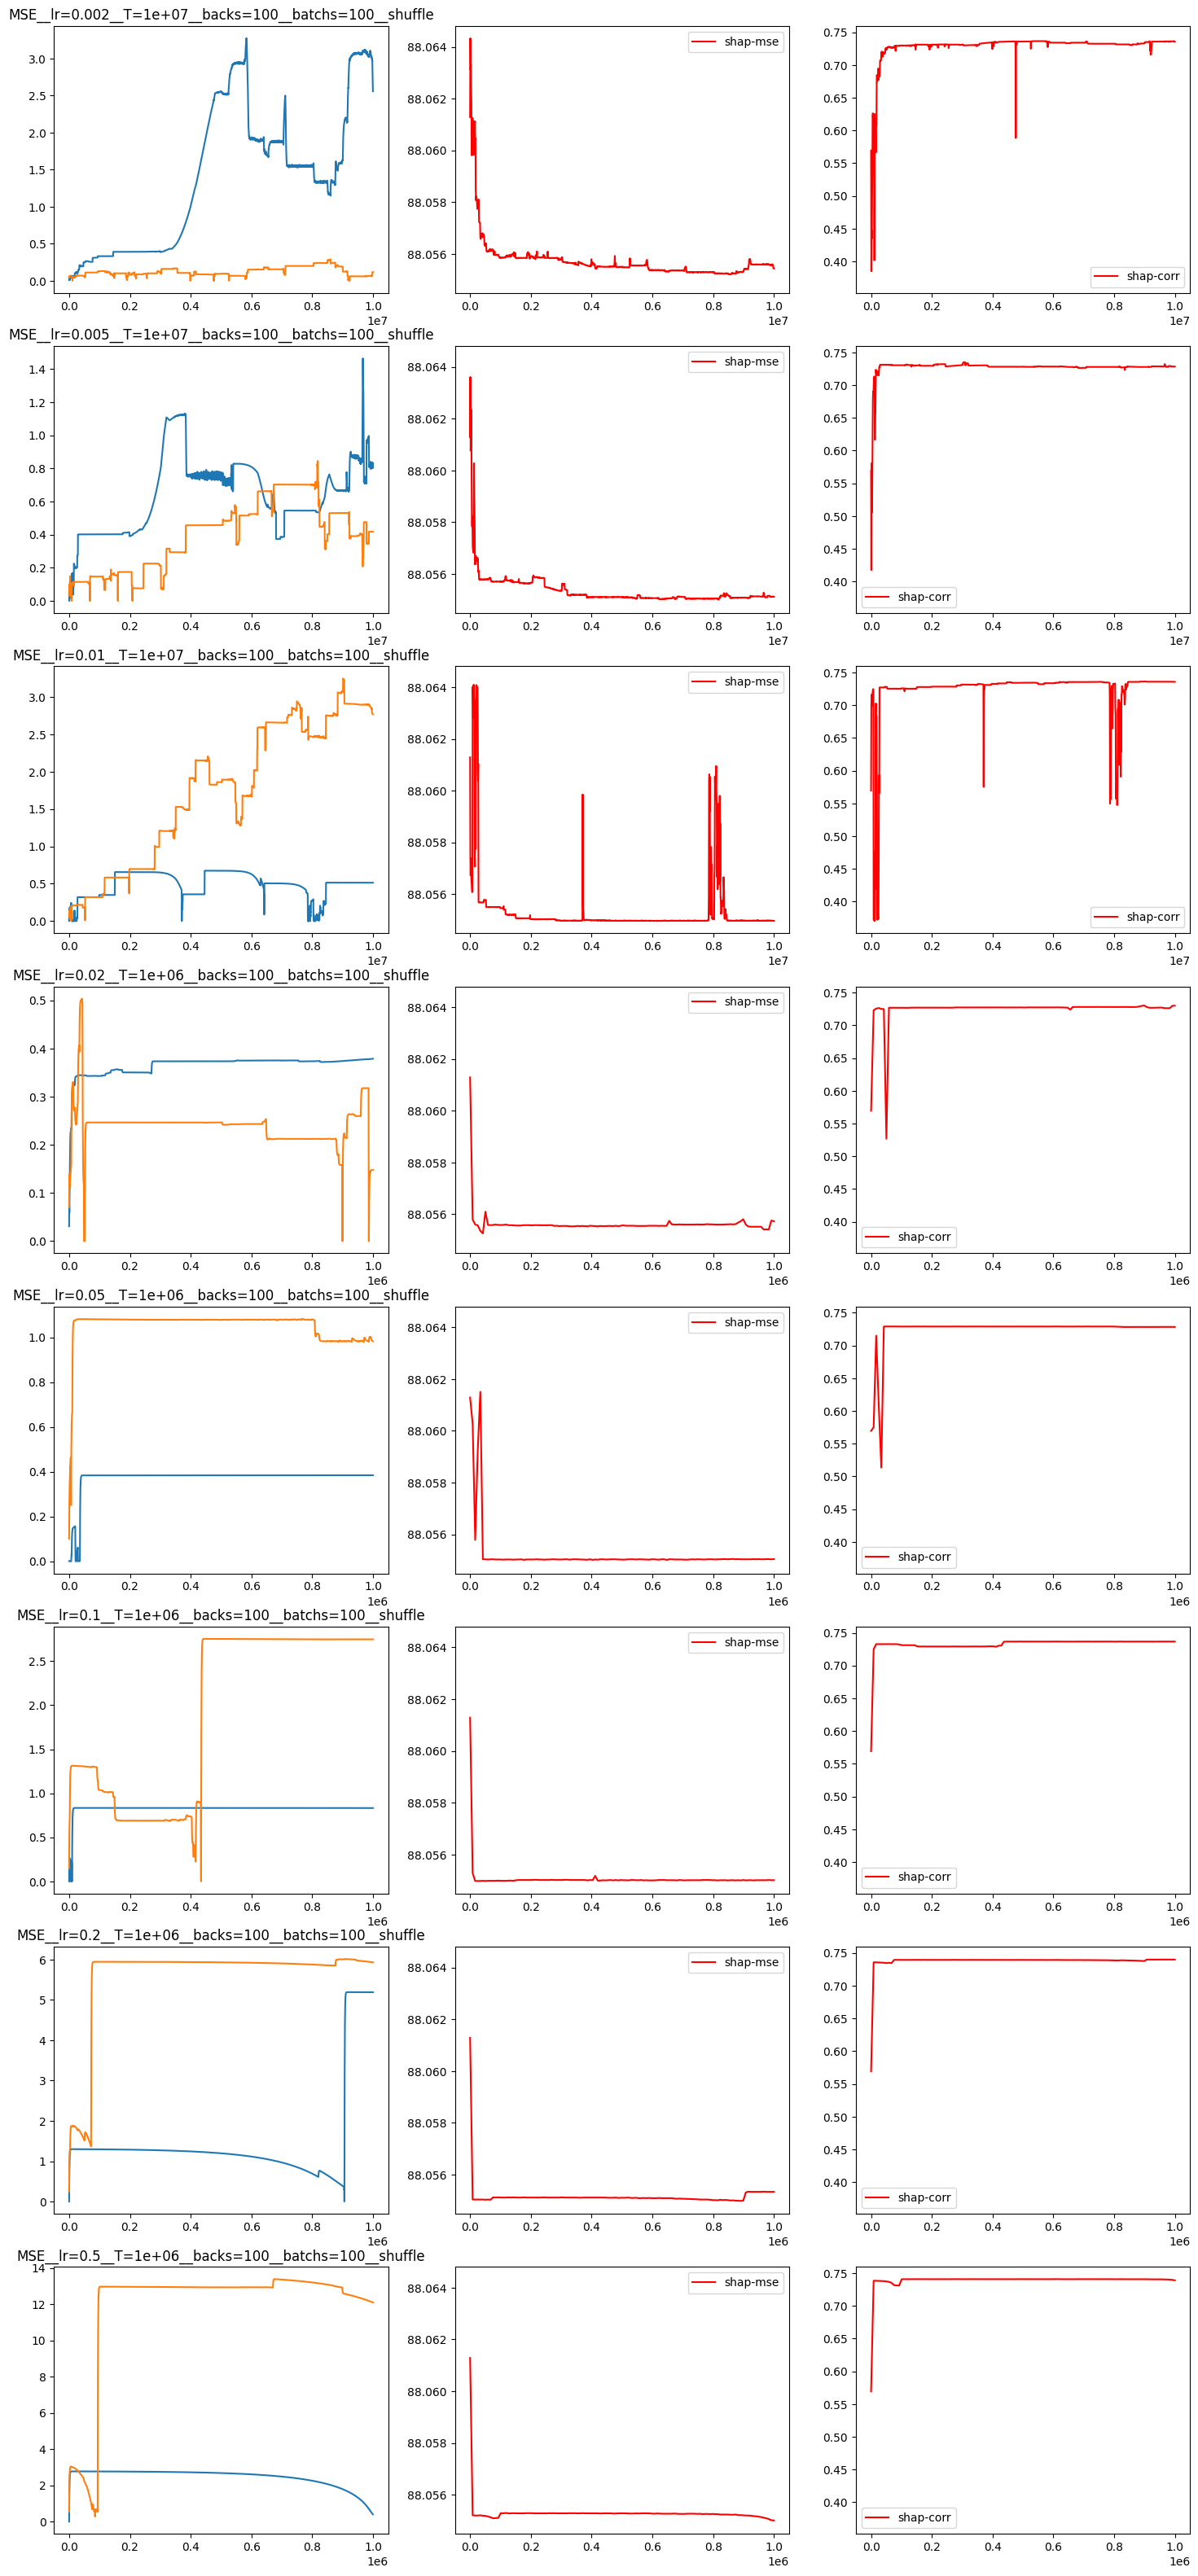

In [85]:
n_cols = 1 + 2 # (len(es[0] == 0)
n_rows = len(llrp_tags)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
for tag, axs_row in zip(llrp_tags, axs):
    gs, gs_t, es, es_t, es_tag = load_data('d3', tag)
    
    axs_row[0].plot(gs_t, gs)
    axs_row[0].set_title(tag[73:])

    for i, (e, e_tag) in enumerate(zip(np.array(es).T, es_tag)):
        axs_row[i+1].sharey(axs[0][i+1])
        axs_row[i+1].plot(es_t, e, c='r', label=e_tag)
        axs_row[i+1].legend()

plt.show()

In [87]:
llrp_tags = list(get_matching_tags('d3', ['llrp__V1__model=cb1-8-8-8_cb2-16-16-16_seed-0__loss=shap-prediction_only-MAE']))
[tag[47:] for tag in llrp_tags]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2505/2505 [00:00<00:00, 101959.59it/s]


['loss=shap-prediction_only-MAE__lr=0.002__T=1e+07__backs=100__batchs=100',
 'loss=shap-prediction_only-MAE__lr=0.002__T=1e+07__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.005__T=1e+07__backs=100__batchs=100',
 'loss=shap-prediction_only-MAE__lr=0.005__T=1e+07__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.01__T=1e+07__backs=100__batchs=100',
 'loss=shap-prediction_only-MAE__lr=0.01__T=1e+07__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.02__T=1e+06__backs=100__batchs=100',
 'loss=shap-prediction_only-MAE__lr=0.02__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.05__T=1e+06__backs=100__batchs=100',
 'loss=shap-prediction_only-MAE__lr=0.05__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.1__T=1e+06__backs=100__batchs=100',
 'loss=shap-prediction_only-MAE__lr=0.1__T=1e+06__backs=100__batchs=100__shuffle',
 'loss=shap-prediction_only-MAE__lr=0.2__T=1

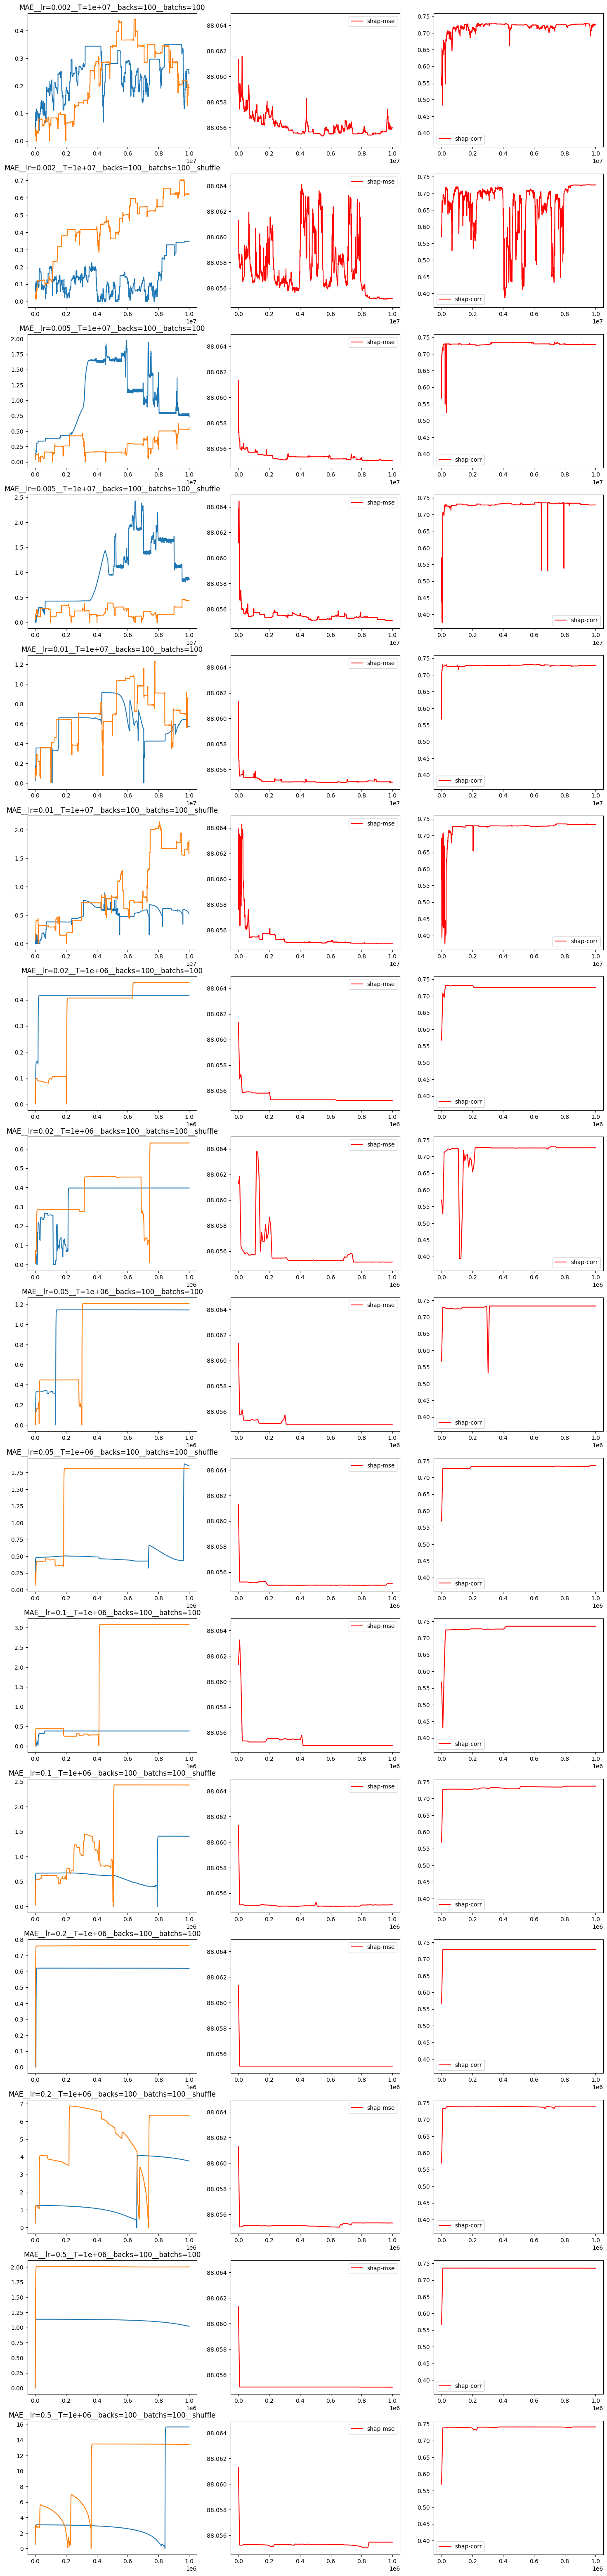

In [82]:
n_cols = 1 + 2 # (len(es[0] == 0)
n_rows = len(llrp_tags)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
for tag, axs_row in zip(llrp_tags, axs):
    gs, gs_t, es, es_t, es_tag = load_data('d3', tag)
    
    axs_row[0].plot(gs_t, gs)
    axs_row[0].set_title(tag[73:])

    for i, (e, e_tag) in enumerate(zip(np.array(es).T, es_tag)):
        axs_row[i+1].sharey(axs[0][i+1])
        axs_row[i+1].plot(es_t, e, c='r', label=e_tag)
        axs_row[i+1].legend()

plt.show()

## Explain class different than Prediction

In [4]:
gamma_early = torch.Tensor([0.5]).requires_grad_(True)
gamma_late  = torch.Tensor([0.1]).requires_grad_(True)

model = ExplainableNet(model_d3).eval().to(device)
model.change_lrp_rules(gamma=gamma_early, lrp_rule_nl=LRPRule.gamma, start_l=0, end_l=3)
model.change_lrp_rules(gamma=gamma_late , lrp_rule_nl=LRPRule.gamma, start_l=4, end_l=8)

In [7]:
for x, target, shap in test_loader_shap:
    expl, acc, class_idx = get_expl(model, x, method)
    break

In [6]:
for x, target, shap in test_loader_shap:
    expl, acc, class_idx, expl_idx = get_expl(model, x, method, desired_index='other')
    break

other


TypeError: randint() received an invalid combination of arguments - got (size=int, high=int, low=int, ), but expected one of:
 * (int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


## Visualize Grid LRP results

In [22]:
%matplotlib inline

In [166]:
tags = list(get_matching_tags('d3', ['gridlrp__V2__model=cb1-8-8-8_cb2-16-16-16_seed-0__backs=100__n_38_r_0_15', 'task']))
len(tags), tags[0], tags[-1]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2505/2505 [00:00<00:00, 104464.55it/s]


(38,
 'gridlrp__V2__model=cb1-8-8-8_cb2-16-16-16_seed-0__backs=100__n_38_r_0_15__task_000_038',
 'gridlrp__V2__model=cb1-8-8-8_cb2-16-16-16_seed-0__backs=100__n_38_r_0_15__task_037_038')

In [167]:
# load data
loaded = [load_data('d3', tag) for tag in tqdm(tags)]
gs = np.vstack([gs for gs, _, _ in loaded])
es = np.vstack([es for _, es, _ in loaded])
es_tag = loaded[0][2]

# order by second, then first column:
order = np.argsort(gs[:, 1] + gs[:, 0] * 1e-4)
gs_ordered = gs[order]
es_ordered = es[order]
# check order 
increasing_or_0 = np.diff(gs_ordered, axis=0) >= 0
increasing_or_0[gs_ordered[1:] == 0] = True
assert np.all(increasing_or_0)

# filter out 0s
mask = np.logical_not(np.any(gs_ordered == 0, axis=1))
gs_ordered = gs_ordered[mask]
es_ordered = es_ordered[mask]

g1s, g2s = np.unique(gs_ordered[:, 0]), np.unique(gs_ordered[:, 1])
g1s, g2s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 321.85it/s]


(array([1.25000000e-02, 2.50000000e-02, 3.75000000e-02, 5.00000000e-02,
        6.25000000e-02, 7.50000000e-02, 8.75000000e-02, 1.00000000e-01,
        1.18860521e-01, 1.41278235e-01, 1.67924046e-01, 1.99595396e-01,
        2.37240127e-01, 2.81984851e-01, 3.35168663e-01, 3.98383219e-01,
        4.73520370e-01, 5.62828779e-01, 6.68981219e-01, 7.95154563e-01,
        9.45124856e-01, 1.12338033e+00, 1.33525571e+00, 1.58709190e+00,
        1.88642570e+00, 2.24221541e+00, 2.66510892e+00, 3.16776235e+00,
        3.76521883e+00, 4.47535872e+00, 5.31943469e+00, 6.32270779e+00,
        7.51520342e+00, 8.93260994e+00, 1.06173467e+01, 1.26198336e+01,
        1.50000000e+01]),
 array([1.25000000e-02, 2.50000000e-02, 3.75000000e-02, 5.00000000e-02,
        6.25000000e-02, 7.50000000e-02, 8.75000000e-02, 1.00000000e-01,
        1.18860521e-01, 1.41278235e-01, 1.67924046e-01, 1.99595396e-01,
        2.37240127e-01, 2.81984851e-01, 3.35168663e-01, 3.98383219e-01,
        4.73520370e-01, 5.62828779e-01

In [165]:
#from copy import deepcopy
#loaded_save = deepcopy(loaded)
loaded_save

[(array([[0.00000000e+00, 0.00000000e+00],
         [1.25000000e-02, 0.00000000e+00],
         [2.50000000e-02, 0.00000000e+00],
         [3.75000000e-02, 0.00000000e+00],
         [5.00000000e-02, 0.00000000e+00],
         [6.25000000e-02, 0.00000000e+00],
         [7.50000000e-02, 0.00000000e+00],
         [8.75000000e-02, 0.00000000e+00],
         [1.00000000e-01, 0.00000000e+00],
         [1.18860521e-01, 0.00000000e+00],
         [1.41278235e-01, 0.00000000e+00],
         [1.67924046e-01, 0.00000000e+00],
         [1.99595396e-01, 0.00000000e+00],
         [2.37240127e-01, 0.00000000e+00],
         [2.81984851e-01, 0.00000000e+00],
         [3.35168663e-01, 0.00000000e+00],
         [3.98383219e-01, 0.00000000e+00],
         [4.73520370e-01, 0.00000000e+00],
         [5.62828779e-01, 0.00000000e+00],
         [6.68981219e-01, 0.00000000e+00],
         [7.95154563e-01, 0.00000000e+00],
         [9.45124856e-01, 0.00000000e+00],
         [1.12338033e+00, 0.00000000e+00],
         [1

In [168]:
best_mse = np.argmax(-es_ordered[:, 0])
best_corr = np.argmax(es_ordered[:, 1])

print('Best MSE ', gs_ordered[best_mse], es_ordered[best_mse, 0])
print('Best Corr', gs_ordered[best_corr], es_ordered[best_corr, 1])

Best MSE  [0.47352037 0.79515456] 2.2480506997005003
Best Corr [0.23724013 0.39838322] 0.4806806404887836


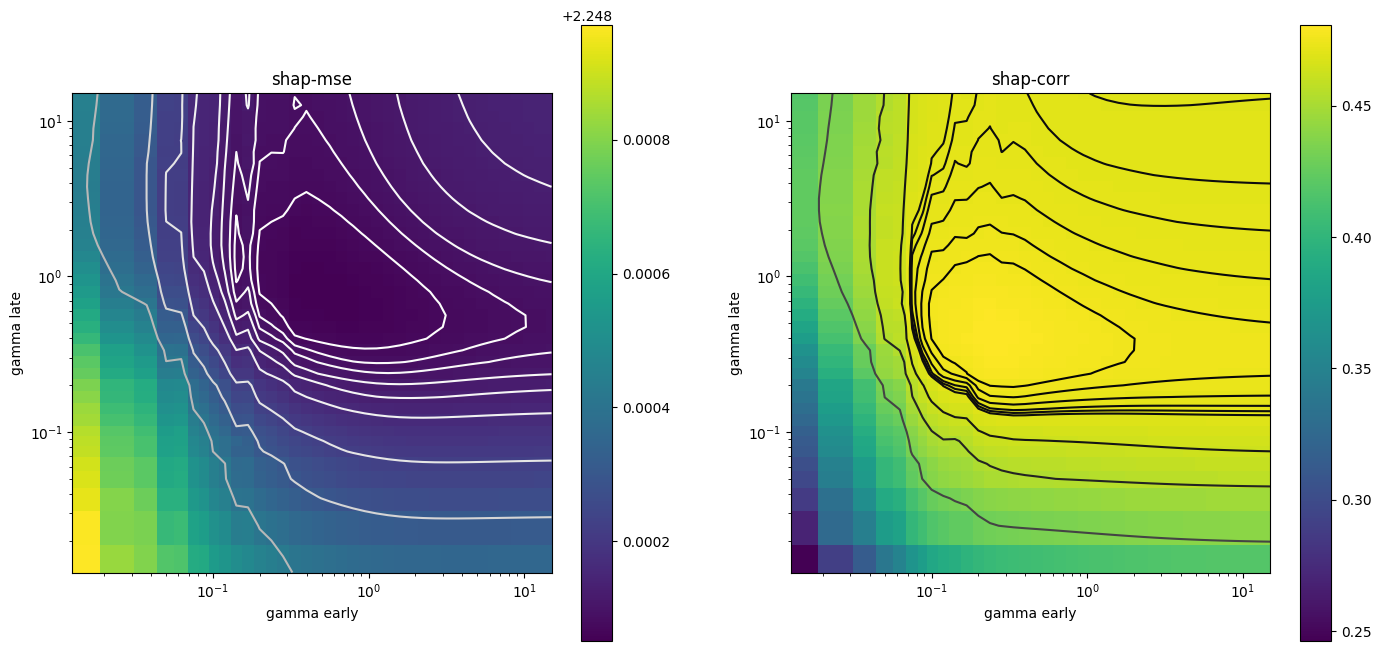

In [164]:
n_contours = 11

fig, axs = plt.subplots(1, len(es_tag), figsize=(17, 8))

for e, e_tag, ax in zip(es_ordered.T, es_tag, axs):
    e = e.reshape((len(g2s), len(g1s)))
    ax.set_title(e_tag)
    plt.colorbar(ax.pcolormesh(g1s, g2s, e))
    if n_contours:
        levels = np.quantile(e, np.linspace(0, 1, n_contours))
        ax.contour(g1s, g2s, e, levels=levels, cmap='Greys')

    ax.set_aspect('equal')
    ax.set_xlabel('gamma early')
    ax.set_ylabel('gamma late')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(g1s.min(), g1s.max())
    ax.set_ylim(g2s.min(), g2s.max())

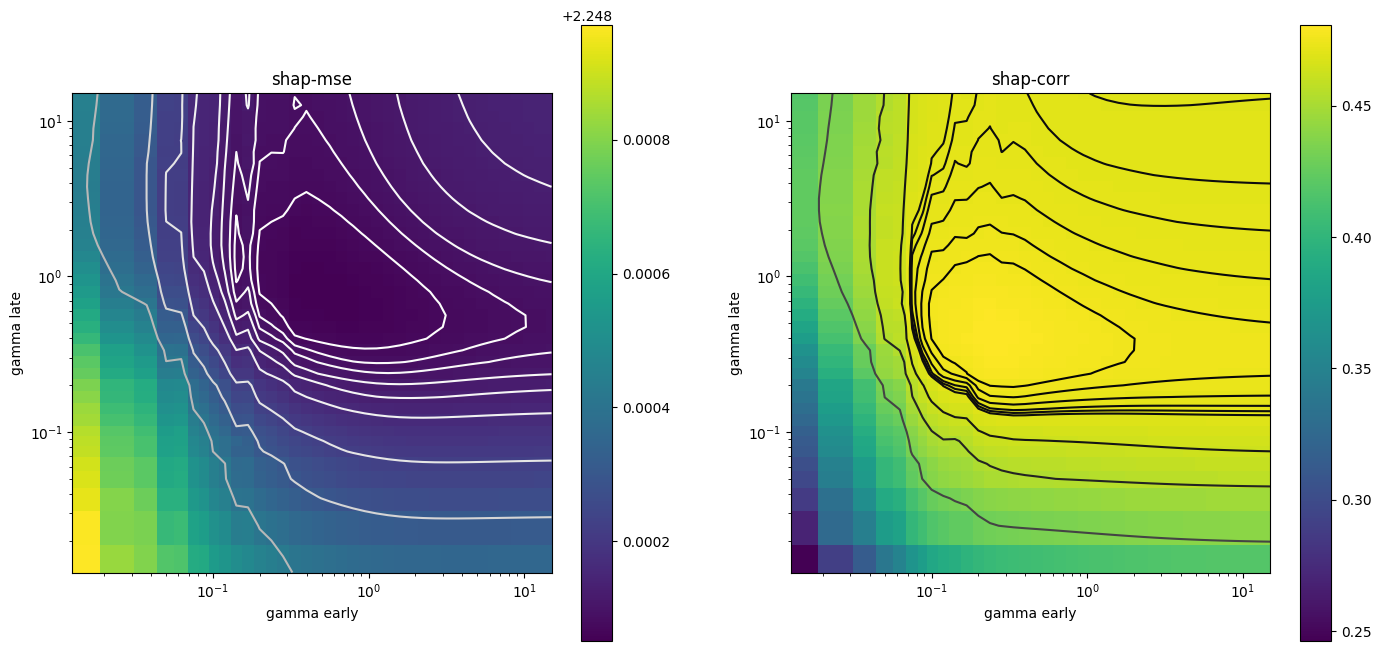

In [99]:
n_contours = 11

fig, axs = plt.subplots(1, len(es_tag), figsize=(17, 8))

for e, e_tag, ax in zip(es_ordered.T, es_tag, axs):
    e = e.reshape((len(g2s), len(g1s)))
    ax.set_title(e_tag)
    plt.colorbar(ax.pcolormesh(g1s, g2s, e))
    if n_contours:
        levels = np.quantile(e, np.linspace(0, 1, n_contours))
        ax.contour(g1s, g2s, e, levels=levels, cmap='Greys')

    ax.set_aspect('equal')
    ax.set_xlabel('gamma early')
    ax.set_ylabel('gamma late')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(g1s.min(), g1s.max())
    ax.set_ylim(g2s.min(), g2s.max())

### Add training trajectories

In [106]:
llrp_tags = list(get_matching_tags('d3', ['llrp__V1__model=cb1-8-8-8_cb2-16-16-16_seed-0', 'MSE', 'shuffle']))
[tag[73:] for tag in llrp_tags]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2505/2505 [00:00<00:00, 103405.59it/s]


['MSE__lr=0.002__T=1e+07__backs=100__batchs=100__shuffle',
 'MSE__lr=0.005__T=1e+07__backs=100__batchs=100__shuffle',
 'MSE__lr=0.01__T=1e+07__backs=100__batchs=100__shuffle',
 'MSE__lr=0.02__T=1e+06__backs=100__batchs=100__shuffle',
 'MSE__lr=0.05__T=1e+06__backs=100__batchs=100__shuffle',
 'MSE__lr=0.1__T=1e+06__backs=100__batchs=100__shuffle',
 'MSE__lr=0.2__T=1e+06__backs=100__batchs=100__shuffle',
 'MSE__lr=0.5__T=1e+06__backs=100__batchs=100__shuffle']

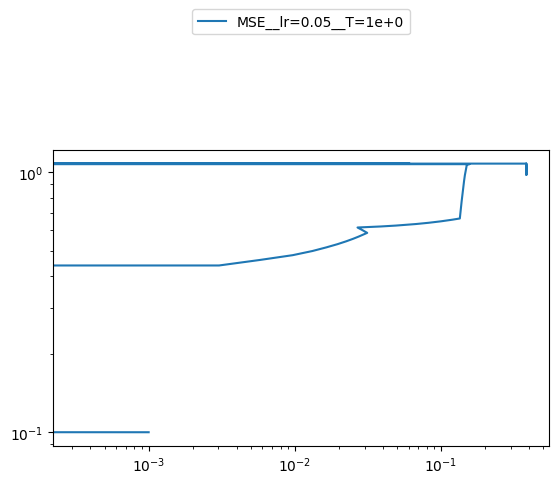

In [162]:
fig, ax = plt.subplots()
cm = plt.get_cmap('viridis')

for tag in llrp_tags[4:]:
    gs, gs_t, es, es_t, es_tag = load_data('d3', tag)
        
    ax.plot(*np.transpose(gs), label=tag[73:93])
    
    diff = np.diff(gs, axis=1)
    angle = np.angle(diff[0] + diff[1]*1j, deg=True)
    
    for i in range(0, len(gs[0]) - 1, 5):
        plt.plot(gs[0][i], gs[1][i], marker=(3, 0, 30+angle[i]), markersize=20, linestyle='None')
    break

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])

# Put a legend to the right of the current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(g1s.min(), g1s.max())
#ax.set_ylim(g2s.min(), g2s.max())

In [94]:
np.transpose(gs)

array([[0.07099999, 0.07020048, 0.06960941, ..., 0.39734441, 0.39734444,
        0.39734447],
       [0.07      , 0.06679023, 0.05387413, ..., 0.6311518 , 0.63115174,
        0.63115168]])

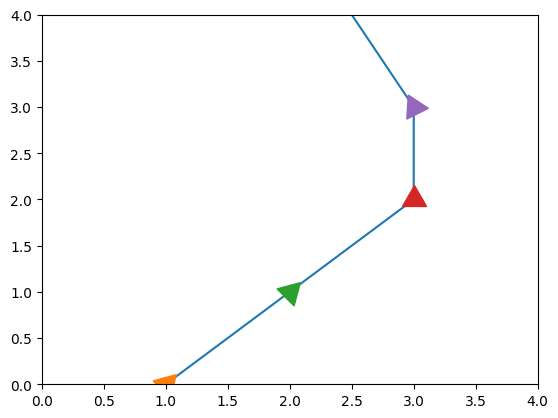

In [157]:
data = np.array(([1,2,3,3,2.5], np.arange(5)))
diff = np.diff(data, axis=1)
angle = np.angle(diff[0] + diff[1]*1j, deg=True)

plt.plot(*data)
              
for i in range(0, data.shape[1] - 1, 5):
    plt.plot(data[0, i], data[1, i], marker=(3, 0, 30+angle[i]), markersize=20, linestyle='None')

plt.xlim([0,4])
plt.ylim([0,4])

plt.show()

In [152]:
np.angle(diff[0] + diff[1]*1j, deg=True)

array([ 45.        ,  45.        ,  90.        , 116.56505118])

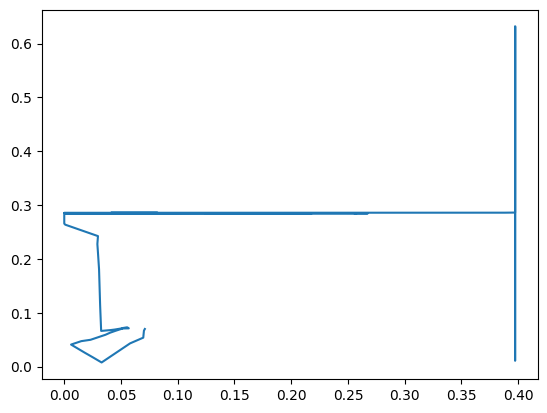

In [92]:
plt.plot(*np.transpose(gs))

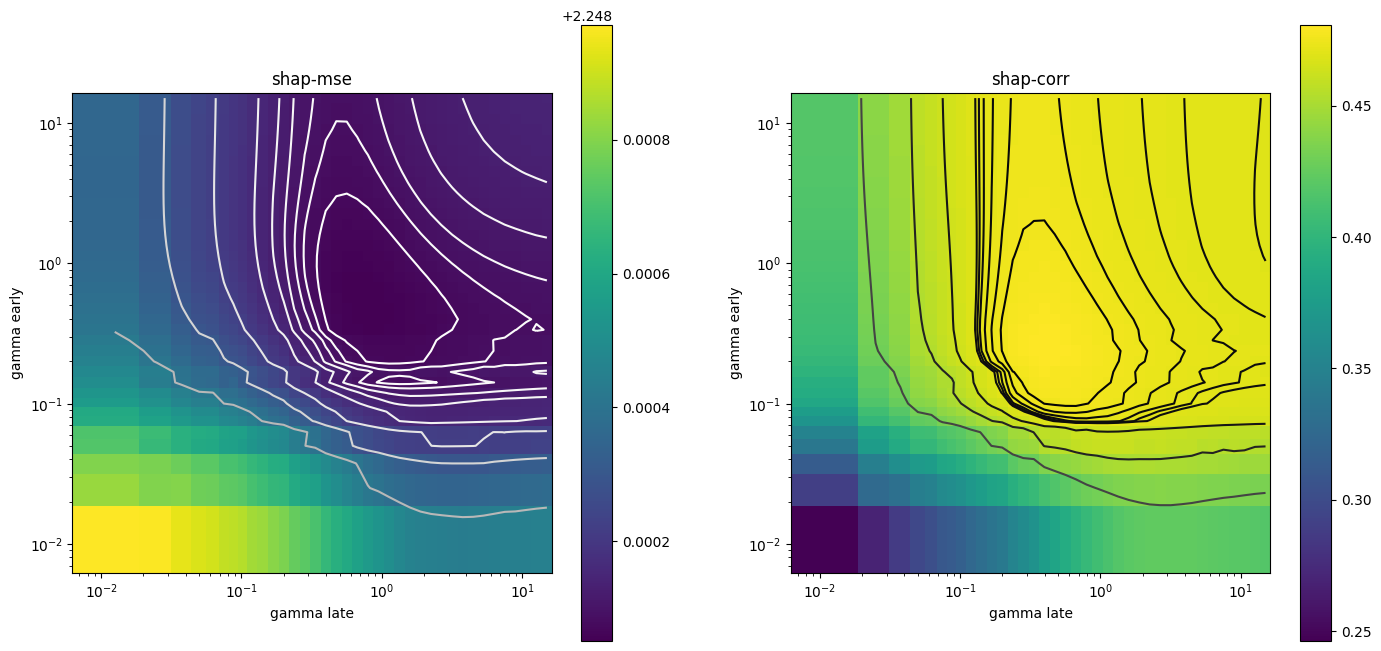

In [65]:
n_contours = 11

fig, axs = plt.subplots(1, len(es_tag), figsize=(17, 8))

for e, e_tag, ax in zip(es_ordered.T, es_tag, axs):
    e = e.reshape((len(g2s), len(g1s)))
    ax.set_title(e_tag)
    plt.colorbar(ax.pcolormesh(g2s, g1s, e.T))
    if n_contours:
        levels = np.quantile(e, np.linspace(0, 1, n_contours))
        ax.contour(g2s, g1s, e.T, levels=levels, cmap='Greys')

    ax.set_aspect('equal')
    ax.set_ylabel('gamma early')
    ax.set_xlabel('gamma late')
    ax.set_yscale('log')
    ax.set_xscale('log')

In [17]:
from matplotlib import cm

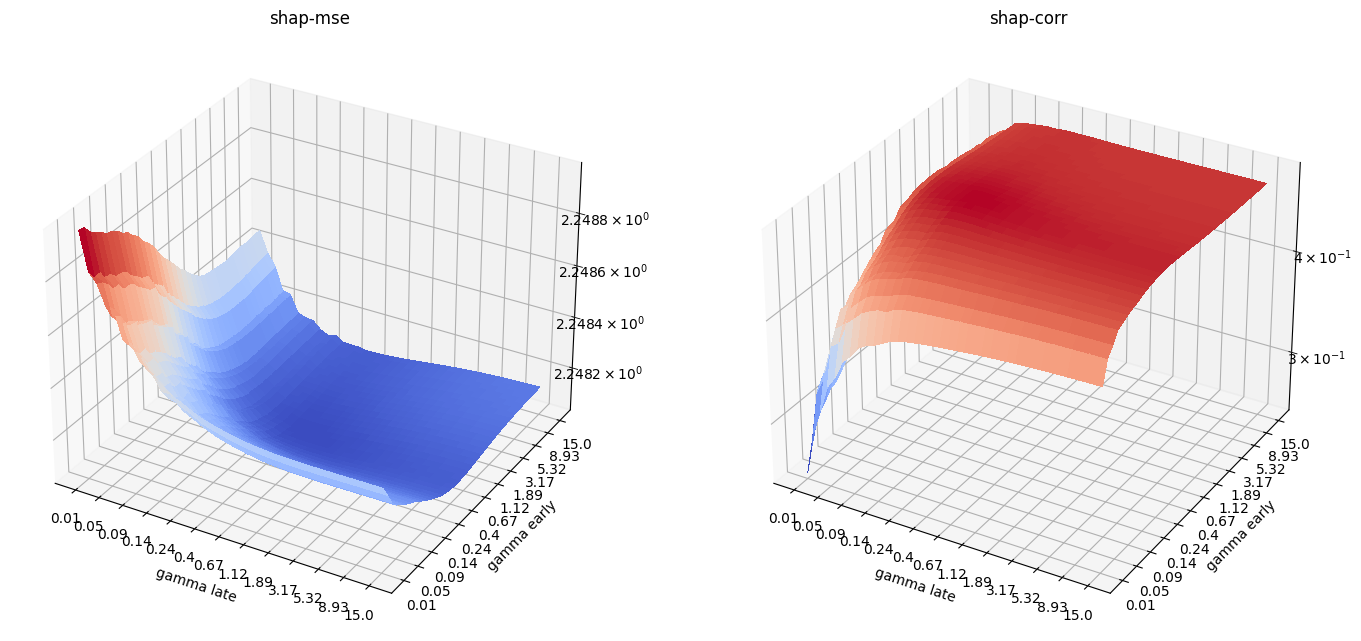

In [72]:
fig, axs = plt.subplots(1, len(es_tag), figsize=(17, 8), subplot_kw={"projection": "3d"})

for e, e_tag, ax in zip(es_ordered.T, es_tag, axs):
    e = e.reshape((len(g2s), len(g1s)))
    # plt.colorbar(ax.pcolormesh(g2s, g1s, e.T))
    
    g2s_tick = np.arange(len(g2s))
    g1s_tick = np.arange(len(g1s))
    
    x = np.outer(g2s_tick, np.ones_like(g1s))
    y = np.outer(g1s_tick, np.ones_like(g2s)).T
    
    ax.plot_surface(x, y, e.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_title(e_tag)
    
    ax.set_aspect('equal')
    ax.set_ylabel('gamma early')
    ax.set_xlabel('gamma late')
    
    plot_every=3
    ax.set_yticks(g2s_tick[::plot_every])
    ax.set_yticklabels(g2s[::plot_every].round(2))
    ax.set_xticks(g1s_tick[::plot_every])
    ax.set_xticklabels(g1s[::plot_every].round(2))
    
    ax.set_zlim(e.min(), e.max())
    ax.set_zscale('log')

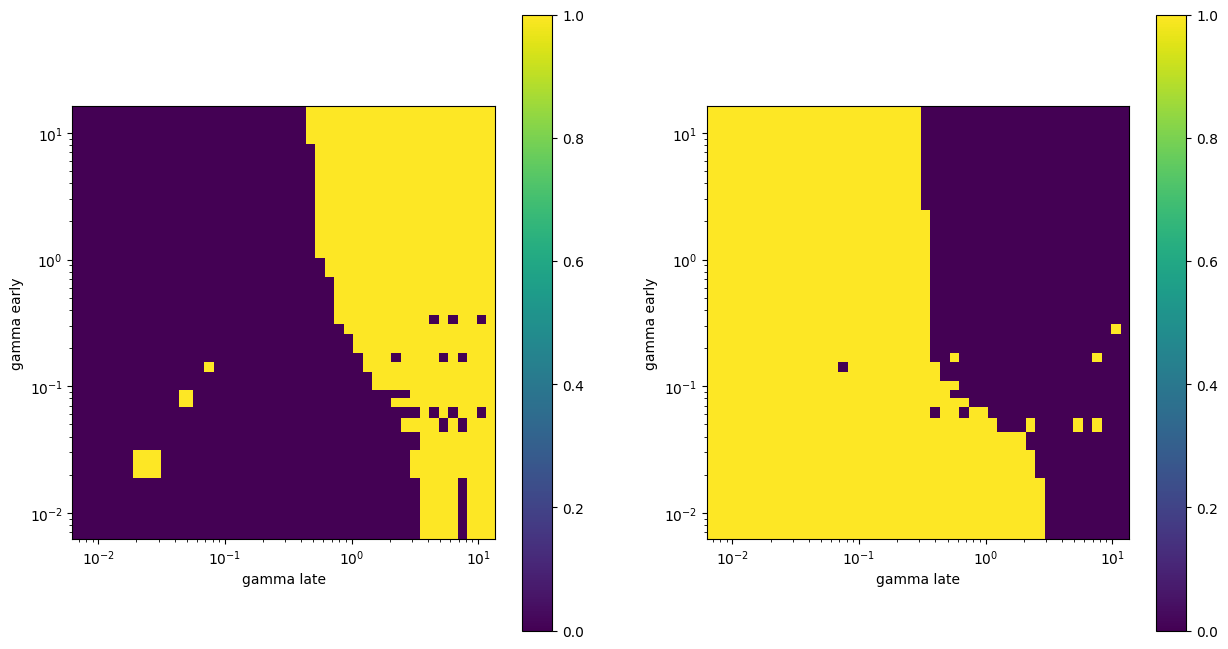

In [70]:
fig, axs = plt.subplots(1, len(es_tag), figsize=(15, 8))

for e, e_tag, ax in zip(es_ordered.T, es_tag, axs):
    e = e.reshape((len(g2s), len(g1s)))
    plt.colorbar(ax.pcolormesh(g2s[:-1], g1s, np.diff(e.T, axis=1)>0))
    
    ax.set_aspect('equal')
    ax.set_ylabel('gamma early')
    ax.set_xlabel('gamma late')
    ax.set_yscale('log')
    ax.set_xscale('log')

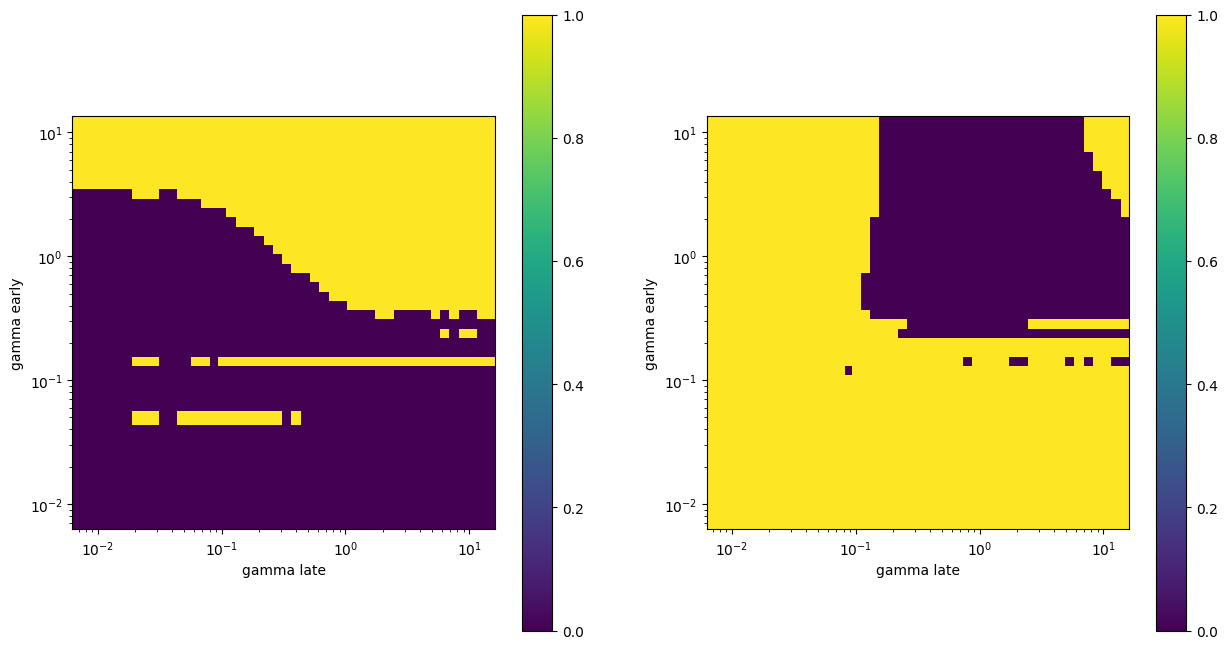

In [71]:
fig, axs = plt.subplots(1, len(es_tag), figsize=(15, 8))

for e, e_tag, ax in zip(es_ordered.T, es_tag, axs):
    e = e.reshape((len(g2s), len(g1s)))
    plt.colorbar(ax.pcolormesh(g2s, g1s[:-1], np.diff(e.T, axis=0)>0))
    
    ax.set_aspect('equal')
    ax.set_ylabel('gamma early')
    ax.set_xlabel('gamma late')
    ax.set_yscale('log')
    ax.set_xscale('log')

## Visualizing how heatmaps change during learning progress

In [ ]:
gs = TODO

In [300]:
# first_batch
data, target, shap = next(iter(test_loader_shap))
data.shape, target.shape, shap.shape

n_img = 5

x = data[:n_img].reshape((-1, 1, 28, 28))
shap_vis = shap[np.arange(n_img), target[:n_img]].transpose(0, 2).reshape((28, 28*n_img))
x.shape, shap_vis.shape

(torch.Size([5, 1, 28, 28]), torch.Size([28, 140]))

Step 0. Avg MSE to SHAP: 88.062286. Avg Pearson Correlation to SHAP: 0.138304.


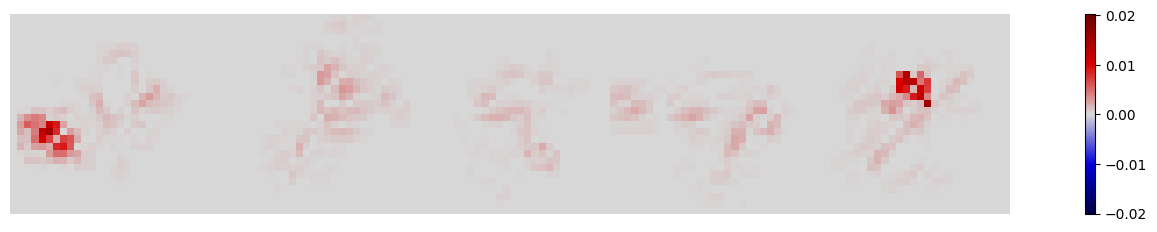

Step 96. Avg MSE to SHAP: 88.057274. Avg Pearson Correlation to SHAP: 0.521521.


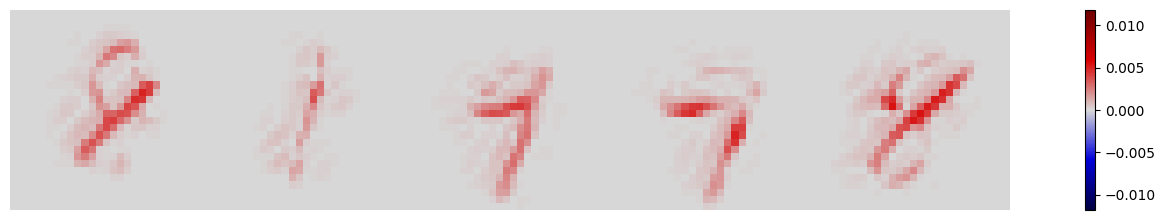

Step 193. Avg MSE to SHAP: 88.063660. Avg Pearson Correlation to SHAP: 0.072433.


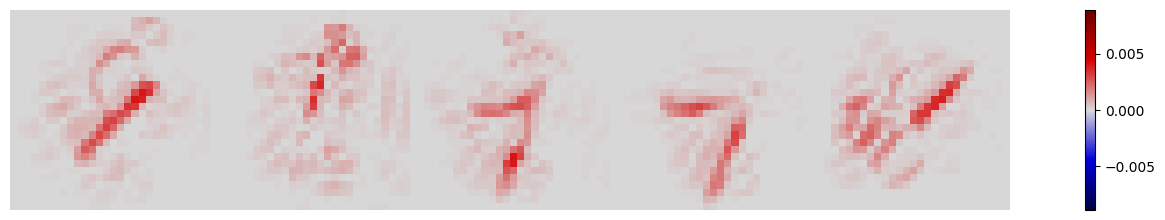

Step 289. Avg MSE to SHAP: 88.055855. Avg Pearson Correlation to SHAP: 0.638156.


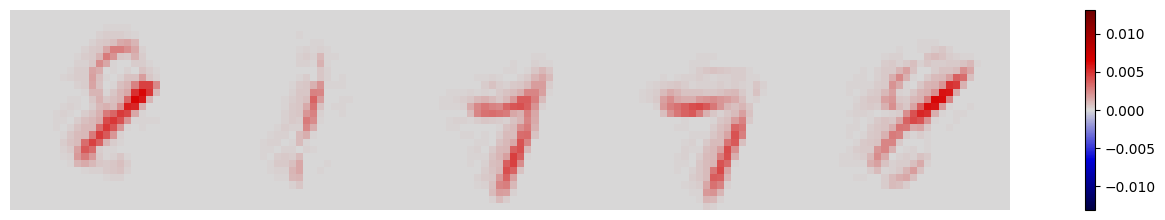

Step 386. Avg MSE to SHAP: 88.055748. Avg Pearson Correlation to SHAP: 0.639239.


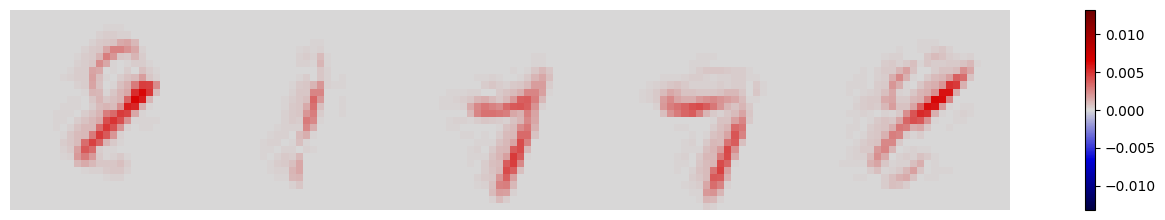

Step 482. Avg MSE to SHAP: 88.055786. Avg Pearson Correlation to SHAP: 0.629419.


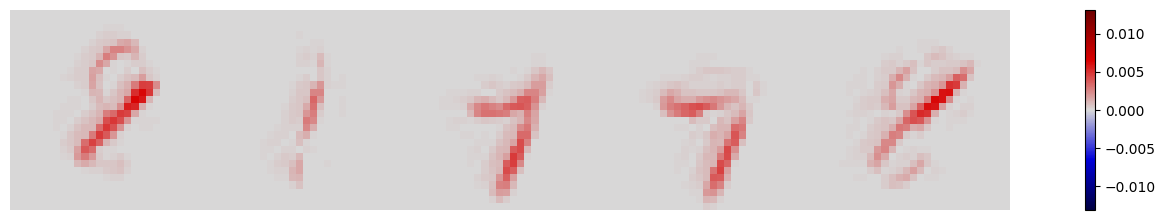

Step 579. Avg MSE to SHAP: 88.055794. Avg Pearson Correlation to SHAP: 0.626089.


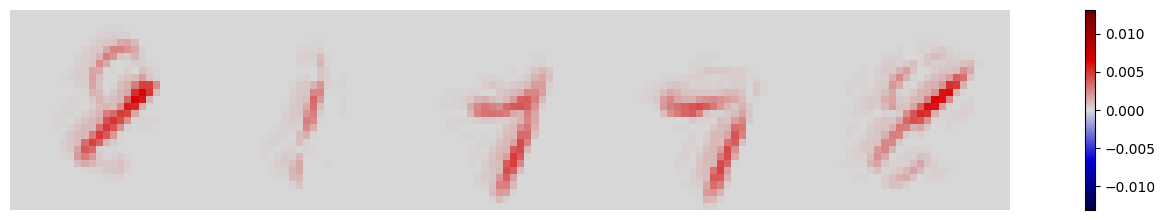

Step 675. Avg MSE to SHAP: 88.055832. Avg Pearson Correlation to SHAP: 0.611062.


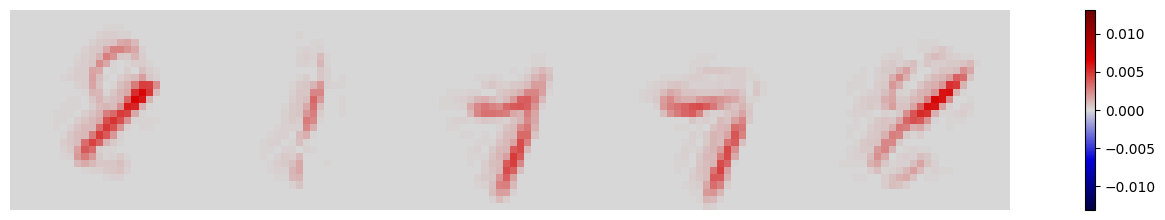

Step 772. Avg MSE to SHAP: 88.055962. Avg Pearson Correlation to SHAP: 0.606407.


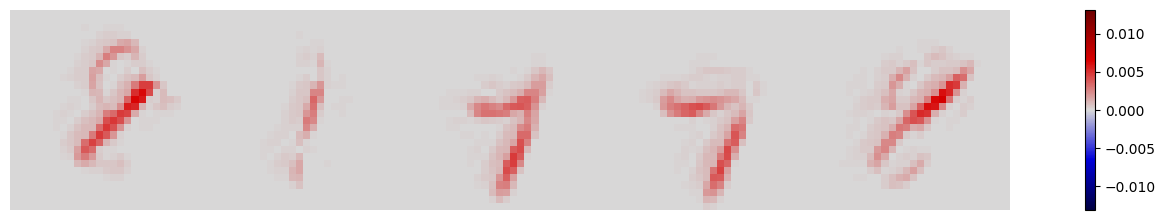

Step 868. Avg MSE to SHAP: 88.055191. Avg Pearson Correlation to SHAP: 0.669030.


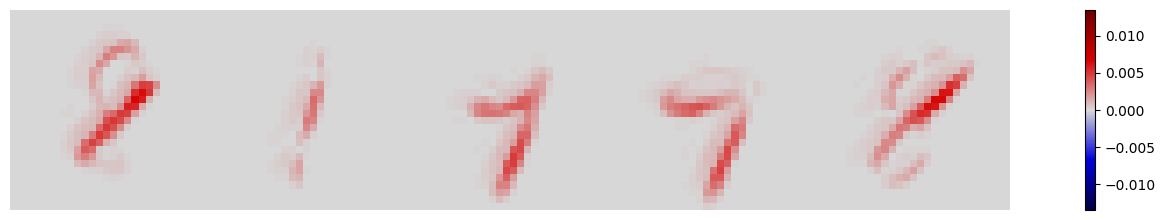

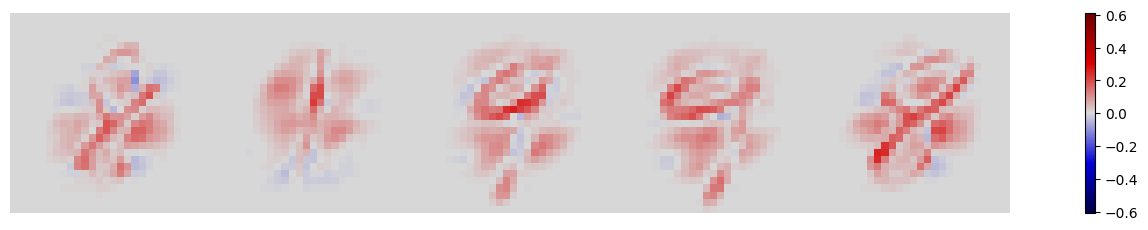

In [301]:
n = 10
l = len(gs)
idx = np.round(np.linspace(0, l - 1, n)).astype(int)

for i in idx:
    test_model = ExplainableNet(model_d3).eval().to(device)
    test_model.change_lrp_rules(gamma=gs[i][0], lrp_rule_nl=LRPRule.gamma, start_l=0, end_l=3)
    test_model.change_lrp_rules(gamma=gs[i][1] , lrp_rule_nl=LRPRule.gamma, start_l=4, end_l=8)
    expl, output, classification = get_expl(test_model, x, method)
    
    with torch.no_grad():
        mse = shap_error(test_model, test_loader_shap, 'mse')
        corr = shap_error(test_model, test_loader_shap, 'corr')
        print(f"Step {gs_t[i]}. Avg MSE to SHAP: {mse:6f}. Avg Pearson Correlation to SHAP: {corr:1f}. Gammas:{[g.round(2) for g in gs]}")

        vis = expl.transpose(0,1).reshape((28, 28*n_img))
        heatmap(vis, sx=3*n_img, colorbar=True)
        plt.show()
    
heatmap(shap_vis, sx=3*n_img, colorbar=True)
plt.show()

#### minimize MSE to shapley values (first batch only)

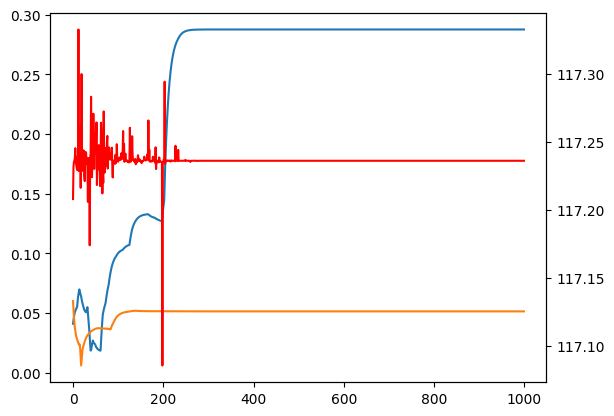

In [189]:
tag = 'results__SGD_shap__batch1__MSE_v1'
# save_data('d3', tag, (gammas, losses))

gs, ls = load_data('d3', tag)

fig, ax = plt.subplots()
ax.plot(gs)
ax.twinx().plot(ls, c='r')

## LRP computation (my implementation)

In [14]:
relevancies_per_mode = {}

In [15]:
modes = {
    0: "LRP-0.", 
    1: "Gamma. l<4 gamma=0.125",
    2: "Gamma. l<4 gamma=0.25",
    3: "Gamma. l<4 gamma=0.5",
    
    92: "Gamma. l<1000 gamma=0.25",
    95: "Gamma. l<1000 gamma=2.",
    99: "Gamma. l<1000 gamma=inf",
   
    # 99: "info."
}

In [16]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [17]:
A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

In [18]:
for mode in tqdm(modes.values()):
    if mode in relevancies_per_mode: continue
    rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
    if mode!="info": relevancies_per_mode[mode] = rels

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
lrp_numpy = rel(92)[0][:3].numpy()
lrp_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in lrp_numpy[None]]

print(np.array(lrp_numpy).shape)

(1, 3, 28, 28, 1)


In [22]:
lrp_numpy[0].shape

(3, 28, 28, 1)

In [27]:
np.array(shap_numpy).shape, np.array(lrp_numpy).shape, test_numpy.shape

NameError: name 'shap_numpy' is not defined

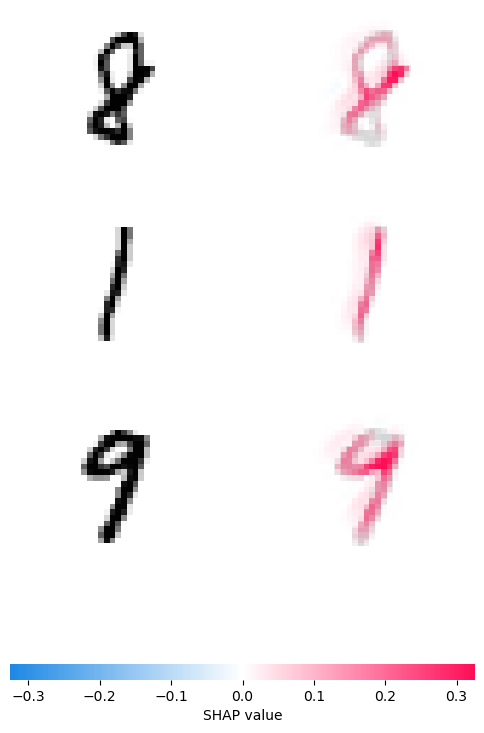

In [30]:
# plot the feature attributions
shap.image_plot(lrp_numpy, -test_numpy)